<a href="https://colab.research.google.com/github/walexi/fellowshipai/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fellowship.AI Challenge: Food-101

## Notebook Layout <a id='top'></a>
  * [Imports](#imports)
  * [Data](#data)
    * [Preparation](#data-preparation)
      * [Class Distribution and Validation](#data-class-dist-val)
    * [Loading](#data-loading)
      * [Transformations](#data-transformations)
  * [Model](#model)
    * [Architecture and Instantiation](#model-architecture-inst)
  * [Training](#training)
    * [Learning Rate](#training-learning-rate)
    * [Fitting](#training-fitting)
    * [Losses](#training-losses)
    * [Image Cleaning](#training-image-cleaning)
    * [Refitting](#training-refitting)
  * [Testing](#testing)
  
Please note that this notebook is structured such that each cell is meant to be run in sequence from top to bottom.

# Imports <a id='imports'></a>
The primary package used in this challenge is [fast.ai's](https://www.fast.ai) fantastic deep learning [library](https://github.com/fastai/fastai). This library is built on top of [PyTorch](https://pytorch.org) and adds a number of convenience functions for data loading, training and testing. Though I will be using much of fast.ai's funcionality in this challenge, I have done my best to thoroughly explain the underlying process and how it sits on top of PyTorch.

Note that despite generally accepted Python practice, fast.ai recommends an import * for ease of use. To be consistent with their conventions I have done that below.

In [0]:
from fastai.vision import *
from fastai.widgets import *
import pandas as pd
import shutil
import os

%matplotlib inline

# Data <a id='data'></a>

## Preparation <a id='data-preparation'></a>
In the following cells, I prepare the data and corresponding labels that will be used to create the data bunch. The data bunch holds the training, validation and test sets and is how the images will be handed to the model. The original data set contains a folder of images by image class and a set of text files describing which images belong to the training and test set--the data bunch will be created from this.

In [0]:
path = Path('data/food-101/')

In [0]:
path.ls()

[PosixPath('data/food-101/images'),
 PosixPath('data/food-101/license_agreement.txt'),
 PosixPath('data/food-101/meta'),
 PosixPath('data/food-101/cleaned.csv'),
 PosixPath('data/food-101/README.txt')]

In [0]:
df_train = pd.read_csv(path/'meta/train.txt', header=None).rename(columns={0:'path'})
df_train['label'] = df_train.path.str.split('/').str[0]
df_train['is_val'] = 0

df_classes = pd.read_csv(path/'meta/classes.txt', header=None).rename(columns={0:'class'})

df_test = pd.read_csv(path/'meta/test.txt', header=None).rename(columns={0:'path'})

df_labels = pd.read_csv(path/'meta/labels.txt', header=None).rename(columns={0:'label'})

In [0]:
df_train.head()

,path,label,is_val
0,apple_pie/1005649,apple_pie,0
1,apple_pie/1014775,apple_pie,0
2,apple_pie/1026328,apple_pie,0
3,apple_pie/1028787,apple_pie,0
4,apple_pie/1043283,apple_pie,0


In [0]:
df_classes.head()

,class
0,apple_pie
1,baby_back_ribs
2,baklava
3,beef_carpaccio
4,beef_tartare


In [0]:
df_test.head()

,path
0,apple_pie/1011328
1,apple_pie/101251
2,apple_pie/1034399
3,apple_pie/103801
4,apple_pie/1038694


In [0]:
df_labels.head()

,label
0,Apple pie
1,Baby back ribs
2,Baklava
3,Beef carpaccio
4,Beef tartare


In [0]:
#Move test files into separate folder
# !mkdir -p data/food-101/images/test
# for i, row in df_test.iterrows():
#     sub_dir = row['path'].split("/")[0]
#     if not os.path.exists(path/'images/test/{0}'.format(sub_dir)):
#         os.makedirs(path/'images/test/{0}'.format(sub_dir))
#     shutil.move(path/'images/{0}.jpg'.format(row['path']), path/'images/test/{0}.jpg'.format(row['path']))

### Class Distribution and Validation <a id='data-class-dist-val'></a>
Below I see that each class has 750 training images in it meaning the training data has an even class distribution. I can select a validation set as a subset of the training data that preserves the class distribution. To do this I simply select a random percentage of each class and assign it to the validation set, i.e. 10% of apple_pie, 10% of chicken_wings, etc.

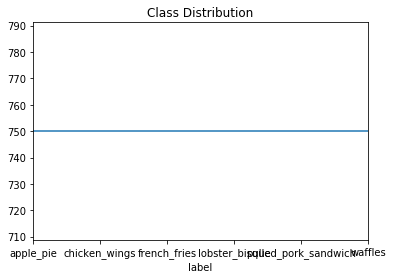

In [0]:
df_train.groupby('label').count()['path'].plot(title='Class Distribution')

In [0]:
images_per_group = 750
val_pct = .1
images_per_val = int(val_pct * images_per_group)
#Group by label and get a random sample within each group, get indices and assign validation flag
val_idx = df_train.groupby('label').apply(lambda x: x.sample(images_per_val)).index.get_level_values(1)
df_train.loc[val_idx, 'is_val'] = 1

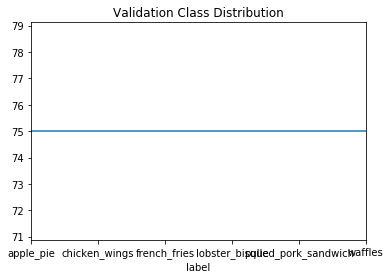

In [0]:
#The validation set preserves the original class distribution
df_train.loc[df_train.is_val == 1].groupby('label').count()['path'].plot(title='Validation Class Distribution')

In [0]:
#df_train.to_csv(path/'meta/train.csv', index=False)
df_train = pd.read_csv(path/'meta/train.csv')

In [0]:
# ###TESTING ONLY###
# train_sample = 200
# train_idx = df_train.groupby('label').apply(lambda x: x.sample(train_sample)).index.get_level_values(1)
# df_train = df_train.loc[train_idx]

## Loading <a id='data-loading'></a>
The data bunch will be instantiated from DataFrame using fast.ai's data block API. A frame specifying the path and label of all training images is passed in first. Next I define how to split out a validation set from the training set and specify what column in the DataFrame contains the image labels. Afterwards I apply image transformations and resize all images to the same size. See below for a more detailed explanation on transformations. Finally I construct the data bunch with a given batch size.

In [0]:
bs=16 #Batch size of 16
size=112 #Image size of 112x112

### Transformations <a id='data-transformations'></a>
Data augmentation is an important part of training computer vision models. Augmentation or transformation is the process by which training images are randomly modified, effectively multiplying the size of the training set without the need for additional images!

fast.ai provides a comprehensive image transformation [library](https://docs.fast.ai/vision.transform.html). Transformations are applied on the fly as images are taken off the data loader. A variety of methods are available including zooming, stretching, brightness, contrast and much more. In this data set I am flipping horizontally but not vertically (as I would not expect to see an image of food upside down). For the rest of the parameters, I tried a variety of values (altering one parameter at a time) to find the optimal value--often the fast.ai default value was the best.

In [0]:
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10.0,
                      max_zoom=1.1,
                      max_lighting=.2,
                      max_warp=.2,
                      p_affine=.75,
                      p_lighting=.75,
                      )

In [0]:
data = (ImageList.from_df(df_train, path=path/'images', suffix='.jpg')
        .split_from_df(col='is_val')
        .label_from_df(cols='label')
        .add_test_folder('test')
        .transform(tfms, size=size)
        .databunch(bs=bs)).normalize(imagenet_stats)

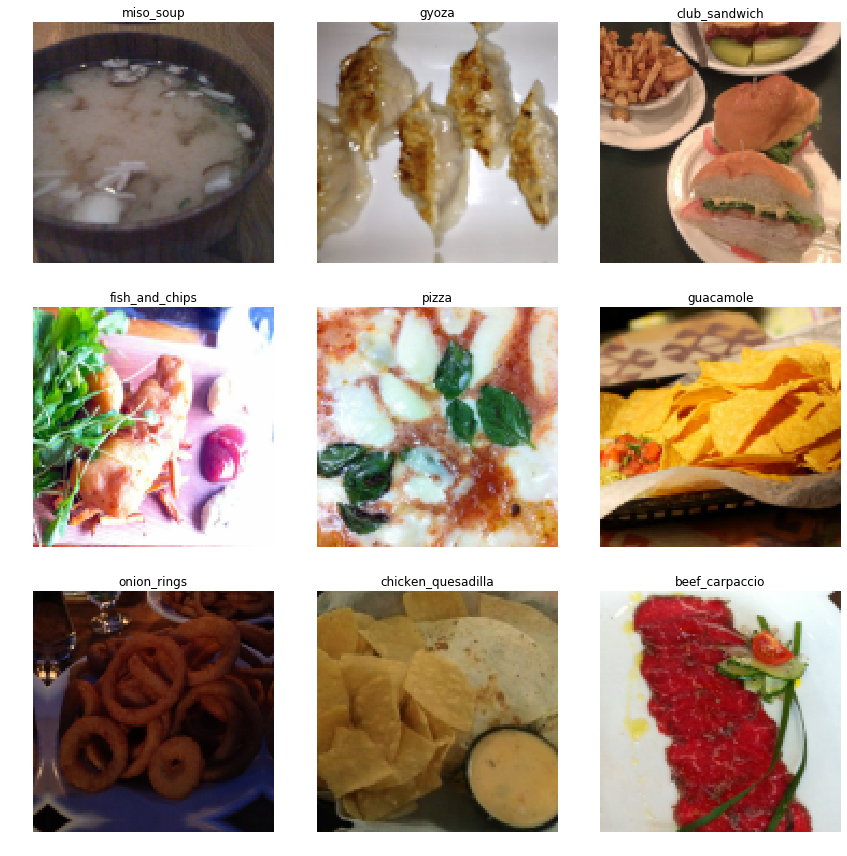

In [0]:
#Preview the data
data.show_batch(rows=3)

# Model <a id='model'></a>

## Architecture and Instantiation <a id='model-architecture-inst'></a>
With the data bunch prepared, I can instantiate the model. fast.ai provides a convenient architecture with its [Learner](https://docs.fast.ai/vision.learner.html) module. Since I will be doing multi-category image recognition I will use a convolutional neural net. Specifically, I will use a [Resnet-50](https://arxiv.org/abs/1512.03385) architecture, pre-trained on [Imagenet](http://image-net.org/challenges/LSVRC/). Pre-training is a very important feature of the model--it leverages weights that have already been trained on the Imagenet dataset as a starting point for the model. The fast.ai Learner uses the pre-trained weights for the bulk of the model but adds additional layers at the end so that the output fits the 101 food classes instead of Imagenet's 1000. Since I will be using weights pre-trained on Imagenet, it is important that the data is normalized by the Imagenet stats (done above).

By default, fast.ai uses [categorical cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) for the loss function in a classification problem like this.

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

# Training <a id='training'></a>

## Learning Rate <a id='training-learning-rate'></a>
The first step to training is determining the learning rate to use. The learning rate defines the size of the step taken in Stochastic Gradient Descent. A large learning rate can mean faster convergence, but can also skip over local minima and in some cases prevent convergence at all. A small learning rate can mean a more complete coverage of the loss surface but may take a very long time to converge. In fast.ai, a range of learning rates can be specified which allows the model to use a large learning rate at the beginning and smaller learning at the end for fine tuning. Using the lr_find function, I can find the optimal range of learning rates to pass to the Learner.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


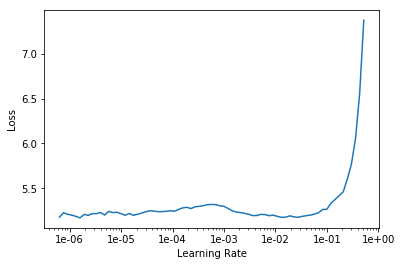

In [0]:
learn.lr_find()
learn.recorder.plot()

## Fitting <a id='training-fitting'></a>
After finding the learning rate, I can begin fitting the model. By default, fast.ai freezes the pre-trained Imagenet layers and only trains the additional layers it has added on. I start by fitting these additional layers first. After sufficient training, I unfreeze the pre-trained layers and train those as well. 

Note that I am fitting with weight decay of .01. Weight decay is a form of regularization that penalizes weights for being too large. After trying a variety of weight decay numbers I found .01 to be the best.

In [0]:
learn.fit_one_cycle(8, max_lr=slice(1e-4, 1e-3), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,2.922651,2.501429,0.397524,04:16
1,2.371301,2.008254,0.498683,04:12
2,2.146966,1.806749,0.540701,04:12
3,2.022726,1.682790,0.570074,04:11
4,1.976013,1.596021,0.592071,04:11
5,1.749519,1.536566,0.608404,04:11
6,1.652880,1.493685,0.616438,04:11
7,1.743597,1.494321,0.618546,04:11


In [0]:
learn.save('stage-112-1')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.755946,1.446508,0.631322,06:29
1,1.622002,1.366897,0.646470,06:28
2,1.466238,1.272341,0.671628,06:28
3,1.241964,1.188362,0.695074,06:28
4,1.080136,1.144930,0.702582,06:28


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
learn.freeze()

In [0]:
learn.save('stage-112-2')

## Losses <a id='training-losses'></a>
After a few rounds of fitting, I take a look at some results--specifically the top losses of the model. Looking at the first few images, it is clear that some of the photos are actually mislabeled and the model is predicting them correctly. Not only does this impact the validation score but also the original training itself.

In [0]:
val_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
val_losses,val_idxs = interp.top_losses()

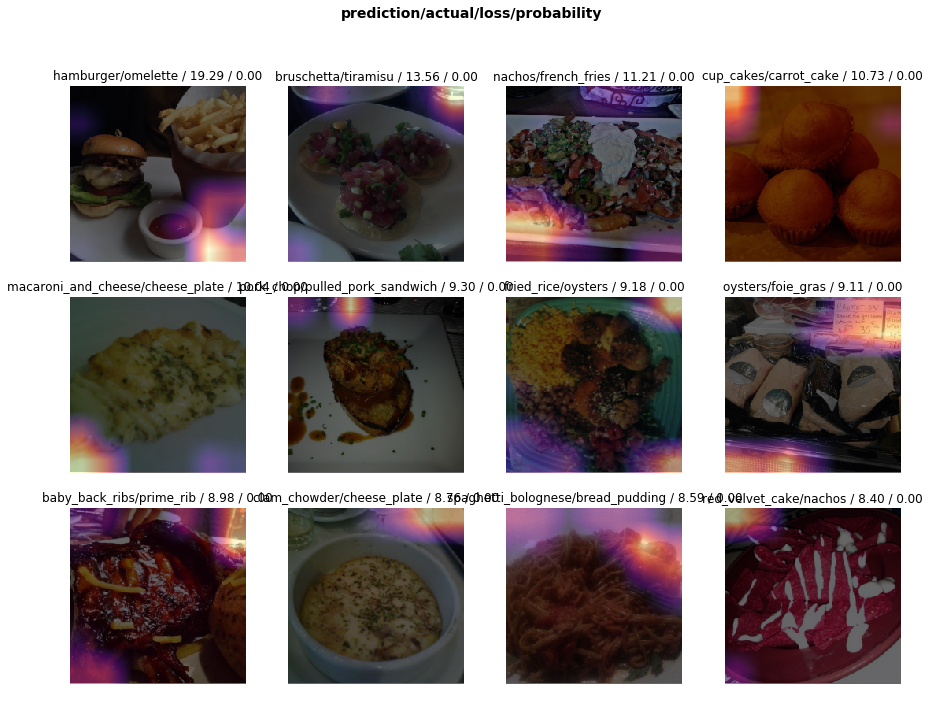

In [0]:
val_interp.plot_top_losses(12, figsize=(15,11))

In [0]:
train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)
train_losses,train_idxs = interp.top_losses()

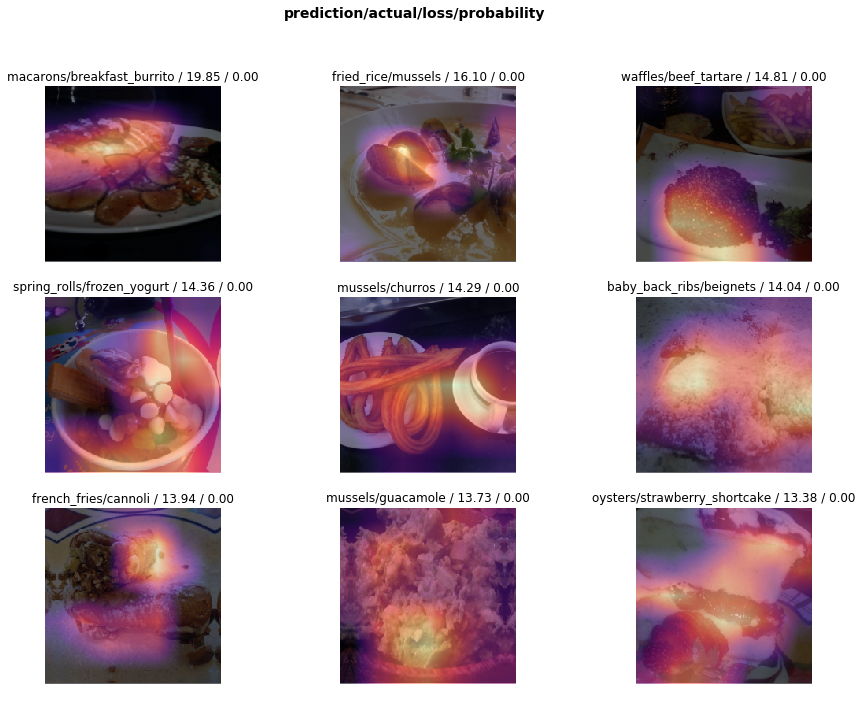

In [0]:
train_interp.plot_top_losses(9, figsize=(15,11))

## Image Cleaning <a id='training-image-cleaning'></a>
Using the losses and fast.ai's ImageCleaner widget, I delete irrelevant or unclassifiable images and reclassify images where possible. I then re-save the resulting csv and reload the data.

In [0]:
ImageCleaner(data.valid_ds, val_idxs[:100], path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [0]:
df_clean_val = pd.read_csv(path/'cleaned.csv')
df_clean_val['is_val'] = 1
df_clean_val['name'] = df_clean_val.name.str.replace("images/", "")
df_clean_val['name'] = df_clean_val.name.str.replace(".jpg", "")
df_clean_val = df_clean_val.rename(columns={'name':'path'})
df_train = df_train.loc[df_train.is_val == 0]
df_train = df_train.append(df_clean_val)
df_train.to_csv(path/'meta/train.csv', index=False)

In [0]:
learn.data = (ImageList.from_df(df_train, path=path/'images', suffix='.jpg')
              .split_from_df(col='is_val')
              .label_from_df(cols='label')
              .add_test_folder('test')
              .transform(tfms, size=size)
              .databunch(bs=bs)).normalize(imagenet_stats)

## Refitting <a id='training-refitting'></a>
With the images cleaned I begin refitting for a few more epochs. After that, I reload the data with a larger image size and again fit for a few more epochs. I first size up from 112 to 224 and finally from 224 to 512.

In [0]:
learn.fit_one_cycle(1, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.062185,1.143742,0.704162,04:14


In [0]:
bs_resize = 16 #decrease batchsize for larger images
size_resize = 224 #increase image size

learn.data = (ImageList.from_df(df_train, path=path/'images', suffix='.jpg')
              .split_from_df(col='is_val')
              .label_from_df(cols='label')
              .add_test_folder('test')
              .transform(tfms, size=size_resize)
              .databunch(bs=bs_resize)).normalize(imagenet_stats)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


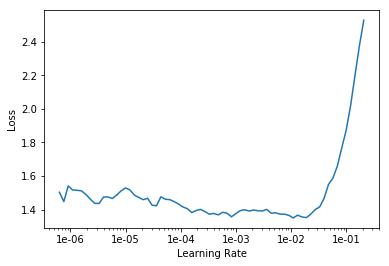

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-4, 1e-3), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.072802,0.916188,0.761986,11:23
1,1.026075,0.894131,0.765543,11:23
2,0.931002,0.848592,0.779636,11:22
3,0.861837,0.839320,0.778583,11:22


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.994689,0.882915,0.763040,15:55
1,0.922399,0.846449,0.778188,15:55
2,0.736911,0.781448,0.797550,15:54
3,0.634899,0.758470,0.804795,15:55


In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.809180,0.836546,0.786618,15:55
1,0.544334,0.751395,0.807165,15:56


In [0]:
learn.save('stage-224-1')

In [0]:
bs_resize = 8 #decrease batchsize for larger images
size_resize = 512 #increase image size

learn.data = (ImageList.from_df(df_train, path=path/'images', suffix='.jpg')
              .split_from_df(col='is_val')
              .label_from_df(cols='label')
              .add_test_folder('test')
              .transform(tfms, size=size_resize)
              .databunch(bs=bs_resize)).normalize(imagenet_stats)

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,1.032611,0.865537,0.776212,1:12:32
1,0.840770,0.734895,0.805717,1:12:22
2,0.719980,0.666680,0.826528,1:12:15


In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.925818,0.798051,0.794652,1:12:20
1,0.768611,0.692403,0.821786,1:12:20
2,0.563378,0.644141,0.834036,1:12:19


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-5, 1e-4), wd=.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.752923,0.758102,0.804926,1:12:21
1,0.775786,0.670640,0.829294,1:12:20
2,0.462993,0.620411,0.842597,1:12:21


In [0]:
learn.save('stage-512-1')

# Testing <a id='testing'></a>
With the model now getting satisfactory validation accuracy, I generate predictions on the test set and compute my final accuracy.

In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
prob, class_idx = preds[0].max(dim=1)
gt_class = np.array([str(x).split("/")[4] for x in list(data.test_ds.x.items)])
pred_class = np.array([data.classes[i] for i in class_idx])

In [0]:
accuracy = np.where(gt_class == pred_class, 1, 0).sum() / len(gt_class); print("Final accuracy: {0}".format(accuracy))

Final accuracy: 0.8868118811881188
